In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [2]:
import numpy as np
from qiskit import *
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import *

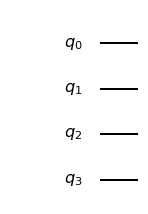

In [3]:
n = 3 #set the length of input string
const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)

const_oracle.draw()


In [4]:
balanced_oracle = QuantumCircuit(n+1)

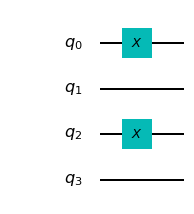

In [5]:
b_str = "101"
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)
balanced_oracle.draw()

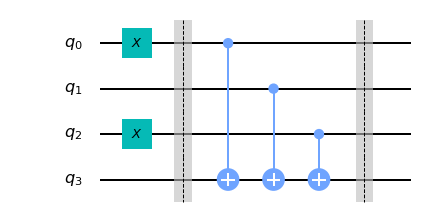

In [6]:
balanced_oracle.barrier()
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()
balanced_oracle.draw()

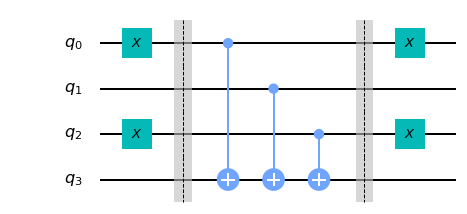

In [7]:
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)
balanced_oracle.draw()

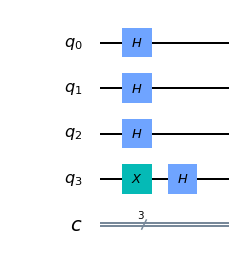

In [9]:
dj_circuit = QuantumCircuit(n+1, n)
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.x(n)
dj_circuit.h(n)
dj_circuit.draw()

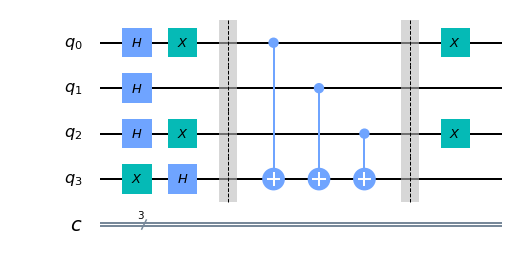

In [10]:
dj_circuit += balanced_oracle
dj_circuit.draw()

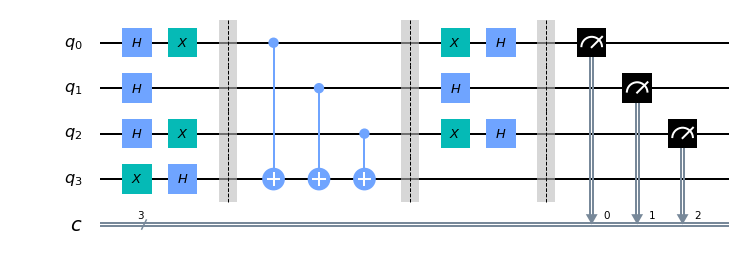

In [11]:
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()
for i in range(n):
    dj_circuit.measure(i, i)
dj_circuit.draw()

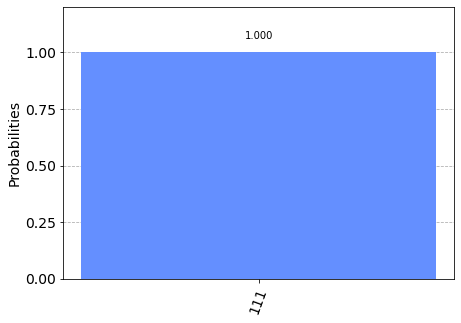

In [12]:
backend = BasicAer.get_backend('qasm_simulator')
result = execute(dj_circuit,backend,shots = 1024).result()
output = result.get_counts()
plot_histogram(output)

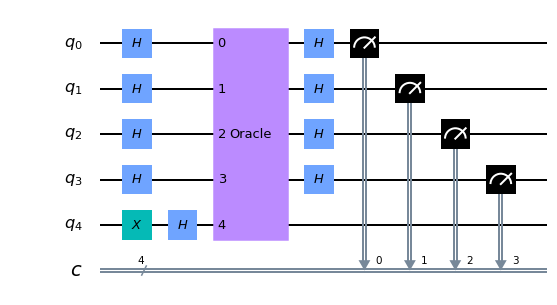

In [13]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit
n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()

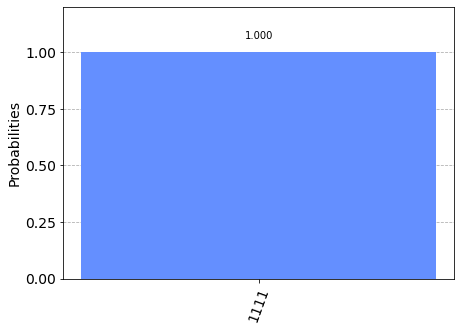

In [14]:
results = execute(dj_circuit, backend=backend, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

In [15]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2020-08-04 13:42:55,169: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmqx2


Job Status: job has successfully run


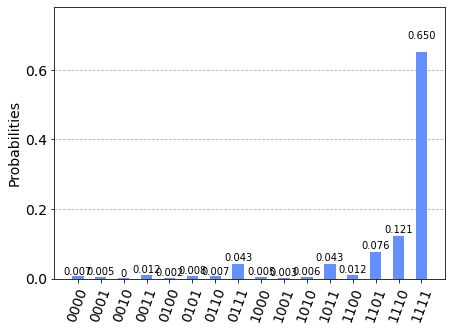

In [16]:
from qiskit.tools.monitor import job_monitor

shots = 1024
job = execute(dj_circuit, backend=backend, shots=shots, optimization_level=3)

job_monitor(job, interval = 2)
results = job.result()
answer = results.get_counts()

plot_histogram(answer)